# LAMMPS Tutorials - melting Temperature. Running your first LAMMPS simulation!

### Author: ABDELLAH TAHIRI 

Please contact me if you have a problem with this tutorial, so I can modify in Github.  I have added FAQs, and will update my versions of LAMMPS in the future to keep the scripts current.

The latest version of this [Jupyter Notebook](http://ipython.org/notebook.html) tutorial is available at https://github.com/athiri78/DM/edit/main/LAMMPS-Tutorials.



***

## Description:
<a id="Sec1"></a>

The goal of this script is to simulate the gradual heating of an Aluminum system to observe the melting process, with temperature and other properties being tracked.The script sets up a simulation where Aluminum atoms are simulated using the Embedded Atom Method (EAM) potential. The results from melting_data.txt can be analyzed to determine the melting temperature by examining the change in thermodynamic properties such as pressure, volume, and temperature over time. 



## Step 1: Download an Input File
<a id="Step1"></a>

This input script was run using the Aug 2024 version of LAMMPS. Changes in some commands may require revision of the input script. To get the input file, you have a few options:

*  Copy the text below and paste it into a text file, `melting.in `. Use the `Paste Special` command with unformatted text into the file. 
*  Or, I added the command `%%writefile melting.in` to the Jupyter Notebook which should just do everything for you!




In [37]:
%%writefile melting.in
######################################
# LAMMPS script for Melting Temperature Determination of Aluminum (Al)
# Using EAM potential with gradual heating approach

# ============================ Initialization ============================
units           metal              # Use metal units (energy in eV, length in Angstroms)
boundary        p p p              # Periodic boundary conditions in all directions
atom_style      atomic             # Atomic model for atoms (no bonds)
dimension       3                  # 3D simulation

# ============================ System Creation ==========================
# FCC Aluminum with lattice constant 4.05 Å
lattice         fcc 4.05           # FCC lattice with a 4.05 Å lattice constant
region          box block 0 4 0 4 0 4  # Define simulation region
create_box      1 box              # Create box for 1 type of atoms (Al)
create_atoms    1 box              # Create atoms in the box based on the lattice

# ============================ Potential Setup ==========================
pair_style      eam/alloy          # Using EAM alloy potential for Aluminum
pair_coeff      * * Al99.eam.alloy Al # Load the EAM potential for Aluminum

# ============================ Simulation Settings ======================
timestep        0.001              # 1 fs timestep for metals
neighbor        0.6 bin            # Neighbor list binning with a cutoff of 0.6 Å
neigh_modify    every 5 delay 0 check yes # Update neighbor list every 5 steps

# ============================ Thermodynamic Output =====================
thermo          1000               # Print thermodynamic data every 1000 steps
thermo_style    custom step temp pe ke etotal press vol density # Output custom thermodynamic data

# ============================ Additional Variables ======================
compute         pe_atom all pe/atom          # Compute potential energy per atom
compute         ke_atom all ke/atom          # Compute kinetic energy per atom

# ============================ Initial Velocity & Equilibration ===================
# Set the initial temperature (K)
variable        T_initial equal 250
velocity        all create ${T_initial} 825577 dist gaussian  # Generate velocities with Gaussian distribution

# Equilibrate the system in the NVT ensemble at initial temperature
fix             nvt_equil all nvt temp ${T_initial} ${T_initial} 0.1  # NVT ensemble for equilibration
run             10000                              # Run for 10,000 steps
unfix           nvt_equil                         # Unfix after equilibration

# ============================ Melting Temperature Analysis =====================
# Target temperature for melting study (K)
variable        T_target equal 2000

# Use NPT ensemble for melting study with gradual heating from T_initial to T_target
fix             npt_melt all npt temp ${T_initial} ${T_target} 0.1 iso 0 0 0.1 # NPT ensemble for heating
dump            traj all xyz 10000 melt_traj.xyz  # Dump trajectory data every 10,000 steps
dump_modify     traj element Al  # Define atom type (Al) for trajectory output

# Collect thermodynamic data for analysis
variable        N equal step
variable        V equal vol
variable        pote equal pe
variable        T equal temp
variable        Et equal etotal
variable        p equal press
fix             data_out all print 2000 "${N} ${T} ${pote} ${Et} ${p} ${V}" file melting_data.txt screen no  # Print data to file
# ============================ Production Run ============================
run             120000  # Run the production for 120,000 timesteps

# ============================ Cleanup ============================
unfix           npt_melt  # Remove the NPT fix after production
unfix           data_out  # Remove data collection fix
undump          traj      # Stop dumping trajectory data

# Print completion message
print "Melting temperature simulation completed successfully"

Overwriting melting.in


Awesome!  That little script should have written the above text to the file `nvt.in`.  To check, let's execute a command on the present directory listing all files that end in `*.in`.

In [39]:
!dir *.in

 Le volume dans le lecteur C n’a pas de nom.
 Le numéro de série du volume est DC02-C1A6

 Répertoire de C:\Users\pc\Desktop\M2A

21/11/2024  11:17             1 774 calc_fcc.in
12/11/2024  15:40             1 565 calc_fcc_ver1.in
09/11/2024  15:10             1 233 calc_fcc_ver2.in
23/12/2024  18:51             3 143 cylindre.in
24/12/2024  00:03             2 878 cylindre_LGV.in
27/02/2025  20:08             2 378 Diatomic.in
03/12/2024  13:22             1 113 Diatomic1.in
12/11/2024  17:49             1 177 lj.in
12/11/2024  18:08               533 ljbarosta.in
12/11/2024  18:19             1 389 ljovito.in
12/11/2024  19:10             1 018 ljrdf.in
12/11/2024  17:59               522 ljthermo.in
01/03/2025  13:26             2 378 lm2a.in
09/04/2025  17:25             3 984 melting.in
25/11/2024  13:17             2 875 minimization.in
25/11/2024  13:45             3 080 minimization1.in
03/12/2024  12:44             1 141 mixed.in
24/12/2024  00:18             1 373 molc.in
22/

***
## Step 2: Running LAMMPS
### Run this using LAMMPS in Jupyter Notebook
We can actually run this from Jupyter Notebook.  Let's try it.

In [41]:
!lmp -in melting.in  -pk omp 8 -sf omp 

LAMMPS (29 Aug 2024 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\LAMMPS 64-bit 29Aug2024\plugins
set 8 OpenMP thread(s) per MPI task
using multi-threaded neighbor list subroutines
Lattice spacing in x,y,z = 4.05 4.05 4.05
Created orthogonal box = (0 0 0) to (16.2 16.2 16.2)
  1 by 1 by 1 MPI processor grid
Created 256 atoms
  using lattice units in orthogonal box = (0 0 0) to (16.2 16.2 16.2)
  create_atoms CPU = 0.002 seconds
Last active /omp style is pair_style eam/alloy/omp
Neighbor list info ...
  update: every = 5 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 6.88721
  ghost atom cutoff = 6.88721
  binsize = 3.443605, bins = 5 5 5
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy/omp, perpetual
      attributes: half, newton on, omp
      pair build: half/bin/newton/atomonly/o

Sweet!

If you want to view the entire file (opening `log.lammps` in Notepad), then:

In [42]:
!type log.lammps

LAMMPS (29 Aug 2024 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\LAMMPS 64-bit 29Aug2024\plugins
package omp 8
set 8 OpenMP thread(s) per MPI task
using multi-threaded neighbor list subroutines
######################################
# LAMMPS script for Melting Temperature Determination of Aluminum (Al)
# Using EAM potential with gradual heating approach

# ============================ Initialization ============================
units           metal              # Use metal units (energy in eV, length in Angstroms)
boundary        p p p              # Periodic boundary conditions in all directions
atom_style      atomic             # Atomic model for atoms (no bonds)
dimension       3                  # 3D simulation

# ============================ System Creation ==========================
# FCC Aluminum with lattice constant 4.05 Ã…
lattice         fcc 4.05           # FC

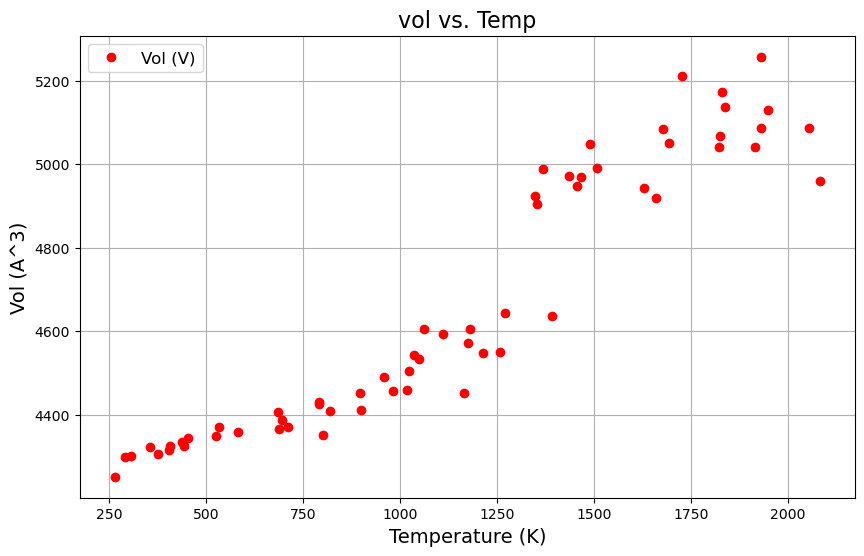

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from file.data
input_file = "melting_data.txt"  # Replace with the file containing the data
data = np.loadtxt(input_file, comments="#")

# Extract relevant columns: Step, KE, PE
V = data[:, 5]  # Column 5: vol
#ke = data[:, 1]     # Column 2: Temperature (T)
Temp = data[:, 1]     # Column 2: Temperature (T)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot KE with red line
plt.plot(Temp, V , color="red", label="Vol (V)", marker='o', linestyle='None', markersize=6, )

# Plot PE with blue line
#plt.plot(steps, pe, color="blue", label="Potential Energy (PE)", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Temperature (K)", fontsize=14)
plt.ylabel("Vol (A^3)", fontsize=14)
plt.title("vol vs. Temp", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Save the plot to a file (optional)
#plt.savefig("energy_plot.png", dpi=300)

# Display the plot
plt.show()

In [ ]:
***
<a id="Sec1"></a>

1. Initialization:
Units and Boundary Conditions: The system is set to use metal units, with periodic boundary conditions (p p p) in all directions.

Atom Style and Dimension: The simulation uses atomic-style particles and runs in 3-dimensional space.

2. System Creation:
Lattice Setup: The Aluminum system is modeled as an FCC (Face-Centered Cubic) lattice with a lattice constant of 4.05 Å, which is typical for Aluminum.

Region and Box Setup: The simulation box is created as a 4x4x4 unit cell.

Atoms: The script generates atoms within the box according to the defined FCC lattice structure.

3. Potential Setup:
The script defines the potential using the EAM (Embedded Atom Method) alloy potential for Aluminum (Al99.eam.alloy).

4. Simulation Settings:
Timestep: The timestep for the simulation is set to 0.001 ps (picoseconds), which is typical for metal simulations.

Neighbor List: The neighbor list is updated every 5 steps, with a cutoff of 0.6 Å.

5. Thermodynamic Output:
The script outputs thermodynamic properties every 1000 timesteps, including:

Step number

Temperature

Potential energy

Kinetic energy

Total energy

Pressure

Volume

Density

Additional properties such as potential energy per atom and kinetic energy per atom are computed for analysis.

6. Initial Velocity and Equilibration:
The system is initialized at a temperature of 250 K (for example) and the velocity distribution is generated using a Gaussian distribution.

NVT Ensemble: The script runs a short equilibration step in the NVT ensemble (constant number of particles, volume, and temperature), where the system is maintained at the initial temperature for 10,000 timesteps.

7. Melting Temperature Analysis:
The target temperature for the melting study is set to 2000 K, with a gradual increase in temperature from the initial 250 K.

NPT Ensemble: The system is run in the NPT ensemble (constant number of particles, pressure, and temperature) to allow for both temperature and volume relaxation as the system is heated from 250 K to 2000 K over time.

Dumping Data: Atomic trajectories are output in XYZ format every 10,000 timesteps. The simulation also tracks various thermodynamic variables, such as temperature, potential energy, and pressure, and writes them to a file melting_data.txt every 1000 timesteps.

8. Production Run:
The simulation runs for 120,000 timesteps, collecting data and continuing the gradual heating process.
<br>

***
## Exercise 
<br>
<div class="alert alert-danger">
<strong>Melting temperature of Cu and Fe</strong>: 

In this exercise, modify the provided LAMMPS script to simulate the melting temperature of Copper (Cu) and Iron (Fe) using the Embedded Atom Method (EAM) potential. also compare the simulated melting temperatures with the experimental values.
<br>
N.B 
Experimental Melting Temperatures:
<br>
*Copper (Cu): Melting temperature ~ 1357 K
<br>
*Iron (Fe): Melting temperature ~ 1811 K (for FCC form, or 1811 K for pure iron in general)
<br>








***
## Tutorial Links

[Click here to open the next tutorial](LAMMPS-Tutorials-02.ipynb)